<a href="https://colab.research.google.com/github/jeffblackadar/image_work/blob/master/Keras_to_Kubernetes_Rao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Found 49 images belonging to 2 classes.
generating images


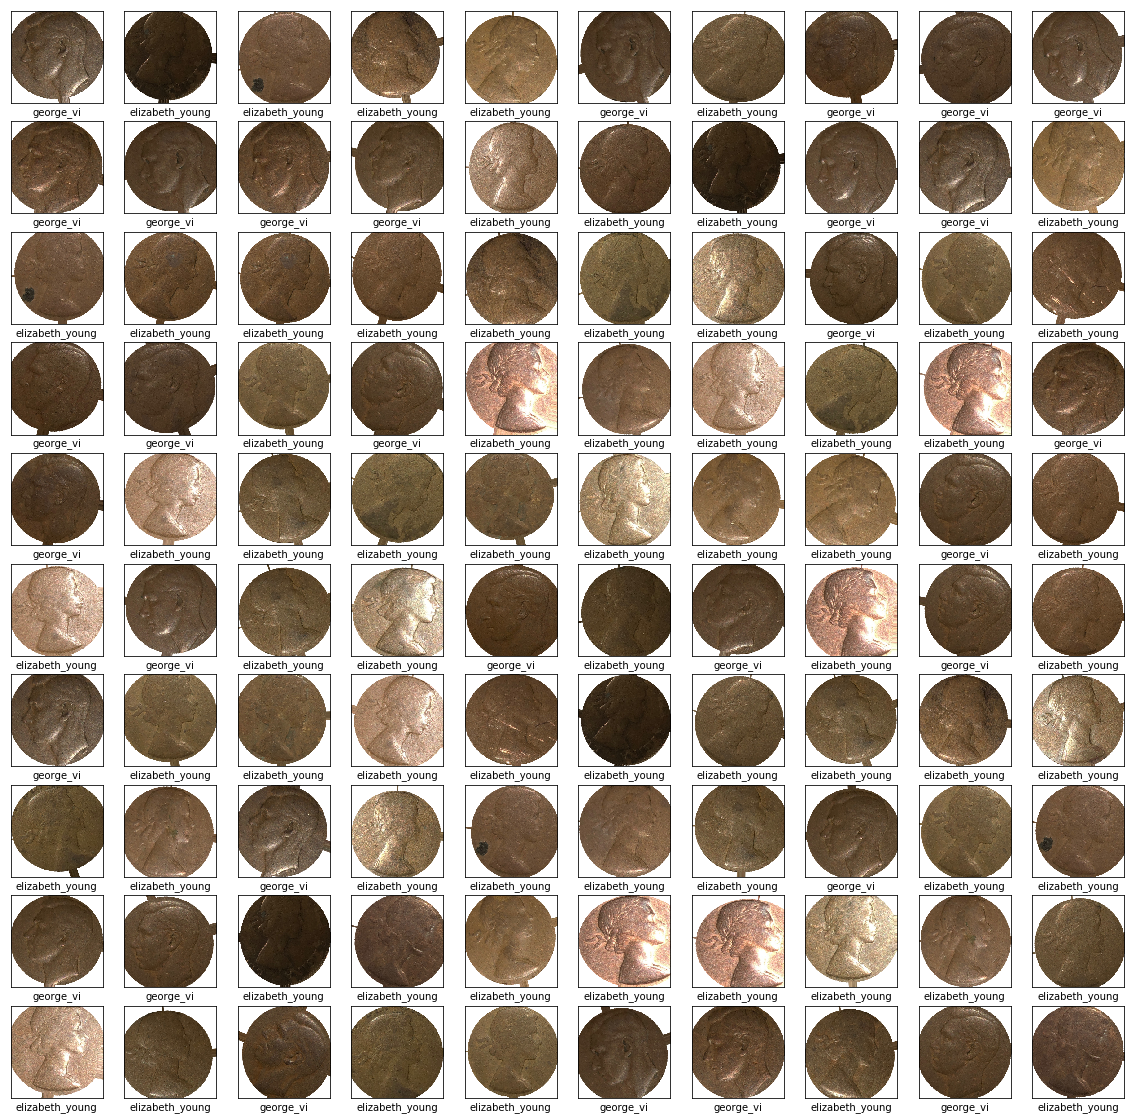

In [27]:
# From:
# Keras to Kubernetes: The Journey of a Machine Learning Model to Production
# Dattaraj Jagdish Rao


from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

training_dir = "/content/drive/My Drive/coin-image-processor/portraits/train"
validation_dir = "/content/drive/My Drive/coin-image-processor/portraits/validation"

gen_batch_size = 1

#This is meant to train the model for images taken at different angles.  I am going to assume pictures of coins are from directly above, so there is little variation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode = "nearest",    
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=20,
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary')

class_names = ['elizabeth_young','george_vi']

print ("generating images")

ROW = 10
plt.figure(figsize=(20,20))
for i in range(ROW*ROW):
    plt.subplot(ROW,ROW,i+1)
    plt.xticks([])
    next_set = train_generator.next()
    plt.imshow(next_set[0][0])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_names[int(next_set[1][0])])
plt.show()
    

In [28]:
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model
from keras import optimizers
from keras.applications.vgg16 import VGG16

img_width,img_height = 300,300

model = VGG16(weights="imagenet",include_top=False, input_shape = (img_width,img_height,3))

for layer in model.layers:
    layer.trainable=False
    
x=model.output
x=Flatten()(x)
x=Dense(512, activation="relu")(x)
x=Dropout(0.5)(x)
x=Dense(64,activation="relu")(x)
predictions=Dense(1,activation="sigmoid")(x)
model_final = Model(input=model.input, output = predictions)
model_final.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [29]:
#listing 5.13 page 157
validation_dir = "/content/drive/My Drive/coin-image-processor/portraits/validation"
gen_batch_size = 1
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300,300),
    batch_size=gen_batch_size,
    class_mode='binary')

Found 45 images belonging to 2 classes.


In [0]:
# listing 5.6 page 135
from keras import optimizers

model_final.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [31]:
#listing 5.14 page 157
#Note, the model must be compiled first
model_final.fit_generator(
    train_generator,
    steps_per_epoch=1000,
    epochs = 2,
    validation_data = validation_generator,
    validation_steps = 100
)

Epoch 1/2
1000/1000 [==============================] - 688s 688ms/step - loss: 0.0299 - acc: 0.9882 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 2/2
1000/1000 [==============================] - 664s 664ms/step - loss: 1.6160e-04 - acc: 0.9999 - val_loss: 0.0195 - val_acc: 0.9800


In [0]:
model_final.save("portrait_model.h5")

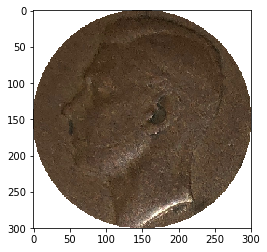

[[1.]]
Prediction for /content/drive/My Drive/coin-image-processor/photos/george_vi/gvi3330.png: george_vi


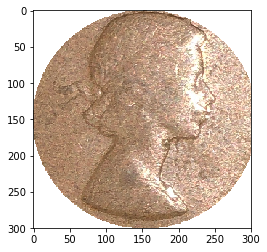

[[0.]]
Prediction for /content/drive/My Drive/coin-image-processor/photos/elizabeth_young/eII2903.png: elizabeth_young


In [33]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

#function that reads image, shows it on screen and makes a prediction

def predict_for(img_name):
    #load image from file - VGG16 takes (244,244) input
    myimg = load_img(img_name, target_size=(300,300))
    plt.imshow(myimg)
    plt.show()

    #convert image pixels to array
    myimg = img_to_array(myimg)
    myimg = np.expand_dims(myimg, axis=0)
    # prepare image for the VGG model
    myimg = preprocess_input(myimg)
    #predict probability for all 1000 classes
    pred=int(model_final.predict(myimg)[0][0])
    print(model_final.predict(myimg))
    print('Prediction for %s: %s'%(img_name, class_names[pred]))


predict_for('/content/drive/My Drive/coin-image-processor/photos/george_vi/gvi3330.png')
predict_for('/content/drive/My Drive/coin-image-processor/photos/elizabeth_young/eII2903.png')
